# Lending Club - Case Study

# Introduction-
This case study aims at identifying risky loan applicants, then such loans can be reduced thereby cutting down the amount of credit loss.

Resources shared: Loan.csv , DataDictionay

In [1]:
#importing libraries 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from matplotlib.transforms import Bbox
warnings.filterwarnings('ignore')

In [2]:
# We start out analysis by first sourcing the data by reading csv

df = pd.read_csv("loan.csv",low_memory=False)

In [3]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


Checking shape of the dataset 

In [4]:
df.shape

(39717, 111)

# Data cleansing
### Remove Nulls
To narrow down our analysis lets findout columns having null values

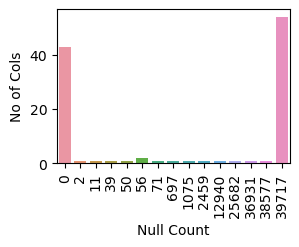

In [5]:
fig, ax = plt.subplots(figsize = (3,2))
plt.xticks(rotation=90) 
# df[df.columns[df.isnull().mean() < 0.8]]
ax = sns.countplot(x =df.isnull().sum(),data = df)
ax.set(xlabel='Null Count', ylabel='No of Cols')
plt.savefig('1_36.png' ,bbox_inches=Bbox([[0,-2],fig.get_size_inches()]))

In [6]:
df.isnull().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

As there are many columns with only null 'NAN' values it do not help in analysis. Hence we can safely drop them

### Columns post dropping nulls
 * Eliminating columns with more than 80% nulls 


In [7]:
df = df[df.columns[df.isnull().mean() < 0.8]]

df.shape

(39717, 55)

### Columns with single unique value
* cannot aid in any categorical analysis

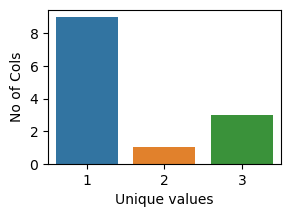

In [8]:
fig, ax = plt.subplots(figsize = (3,2))
plt.xticks(rotation=0) 
df_new = df[df.columns[df.nunique() < 5]]
ax = sns.countplot(x =df_new.nunique(),data = df_new)
ax.set(xlabel='Unique values', ylabel='No of Cols')
plt.savefig('2.png' ,bbox_inches=Bbox([[0,-2],fig.get_size_inches()]))

In [9]:
df.drop(df.columns[df.nunique() ==1],axis=1, inplace = True)
df.shape
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'pub_rec_bankruptcies'],
      dtype='object')

### Elimination based on domain knowledge
- id - (just a unique key identifier do not help in any quantitative or categorical analysis)
- member_id - (just a unique key identifier do not help in any quantitative or categorical analysis)
- url - (Do not aid in analysis)
- emp_title - Too many unique values cannot be categorized
- desc,title - As purpose provides a specific category we can use that for analysis  (desc and title is vague and has lot of distinct values) 
- zip_code - Will not impact loan decision
- delinq_2yrs,earliest_cr_line,mths_since_last_delinq,out_prncp,out_prncp_inv,
  collection_recovery_fee,recoveries,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d - this will happen post loan is granted 

                      

In [10]:
list = ['id','member_id','url','emp_title','desc','title','zip_code','delinq_2yrs','earliest_cr_line','mths_since_last_delinq','out_prncp', 'out_prncp_inv','recoveries',
        'collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','last_credit_pull_d']
df=df.drop(columns=list)
df.shape


(39717, 29)

### Filling Nulls
- Updating null values for the inscope columns
- pub_rec_bankruptcies , revol_util, emp_length can be set to mode 


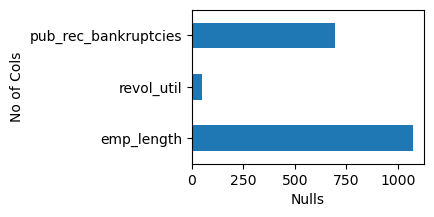

In [11]:
fig, ax = plt.subplots(figsize = (3,2))
a = df[df.columns[df.isnull().sum() != 0]]
a.isnull().sum().plot(kind = "barh")

# plt.xticks(rotation=0) 
# ax = sns.countplot(x = a.isnull().sum(),data = a.columns)
ax.set(xlabel='Nulls', ylabel='No of Cols')
plt.savefig('3.png' ,bbox_inches=Bbox([[-6,0],fig.get_size_inches()]))

df['emp_length'].mode()[0]
df.emp_length.fillna(df.emp_length.mode()[0],inplace=True)
df['pub_rec_bankruptcies'].mode()[0]
df.pub_rec_bankruptcies.fillna(df.pub_rec_bankruptcies.mode()[0],inplace=True)
df['revol_util'].mode()[0]
df.revol_util.fillna(df.revol_util.mode()[0],inplace=True)


### Identify categorical variables 
   - Since only 3 None values in home_ownership updating it to others 

In [12]:


df[df.columns[df.nunique()<15]].head()
df['home_ownership'].replace(to_replace=['NONE'],value='OTHER',inplace=True)


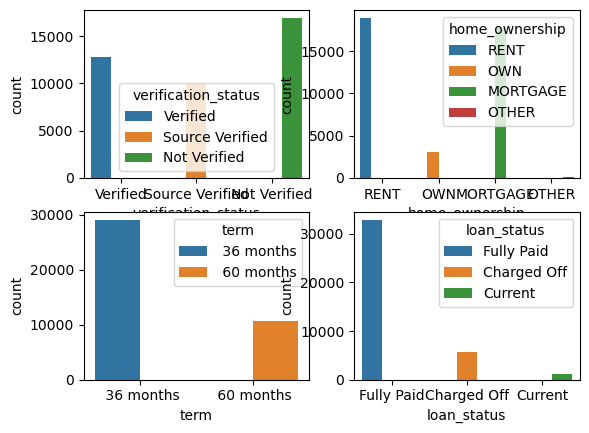

<Figure size 500x600 with 0 Axes>

In [13]:
# fig, ax = plt.subplots(figsize = (2,1))
# sns.countplot(x ='verification_status',hue="verification_status" ,data = df)

facet_fig = plt.figure()
plt.figure(figsize=(5,6))
ax1 = facet_fig.add_subplot(2, 2, 1)
ax2 = facet_fig.add_subplot(2, 2, 2)
ax3 = facet_fig.add_subplot(2, 2, 3)
ax4 = facet_fig.add_subplot(2, 2, 4)    

sns.countplot(x='verification_status', hue='verification_status', ax=ax1,
               data=df)
sns.countplot(x='home_ownership', hue='home_ownership', ax=ax2,
               data=df)
sns.countplot(x='term', hue='term', ax=ax3,
               data=df)
sns.countplot(x='loan_status', hue='loan_status', ax=ax4,
               data=df)
plt.savefig('4.png')


### Derived columns
* converting object to numberic dtypes and extracting numbers from special chars 
* filtering records based on loan status != "Current" as our analysis focus on determining Defaulters or Non defaulters while     neither can be concluded for Current applicants

In [14]:


df.emp_length = pd.to_numeric(df.emp_length.apply(lambda x: 0 if "<" in x else(x.split('+')[0] if "+" in x else x.split()[0])))
df.term = pd.to_numeric(df.term.apply(lambda x: x[0:3]))
df.int_rate = pd.to_numeric(df.int_rate.apply(lambda x: x.split("%")[0]))
df.revol_util = pd.to_numeric(df.revol_util.apply(lambda x: x.split("%")[0]))
df.sub_grade = pd.to_numeric(df.sub_grade.apply(lambda x: x[-1]))
df_final = df[df.loan_status!="Current"]
df_final.info

<bound method DataFrame.info of        loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0           5000         5000           4975.0    36     10.65       162.87   
1           2500         2500           2500.0    60     15.27        59.83   
2           2400         2400           2400.0    36     15.96        84.33   
3          10000        10000          10000.0    36     13.49       339.31   
5           5000         5000           5000.0    36      7.90       156.46   
...          ...          ...              ...   ...       ...          ...   
39712       2500         2500           1075.0    36      8.07        78.42   
39713       8500         8500            875.0    36     10.28       275.38   
39714       5000         5000           1325.0    36      8.07       156.84   
39715       5000         5000            650.0    36      7.43       155.38   
39716       7500         7500            800.0    36     13.75       255.43   

      grade  sub_gr


### Eliminating outliers from summary datasets
* Identifying outliers is an important step as outliers may influence trends and might impact decisioning


[Text(0, 0.5, 'revol_util')]

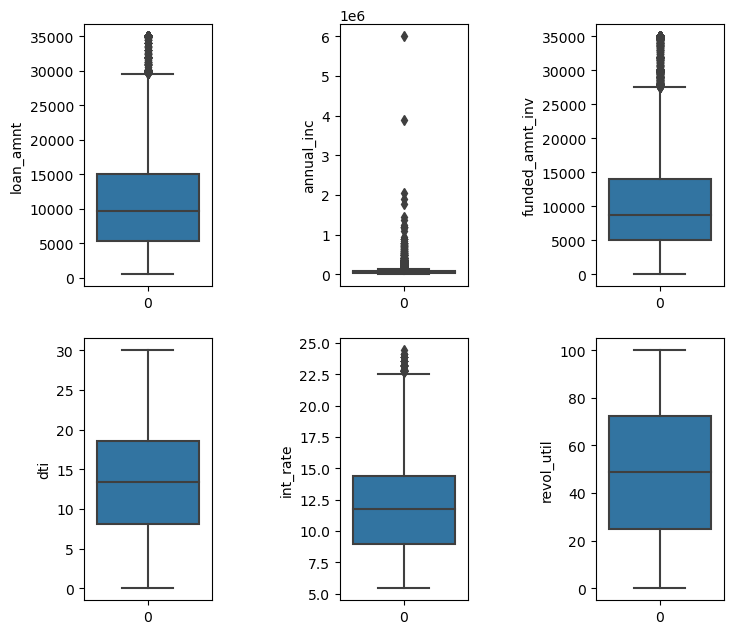

In [15]:
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(left=1, bottom=0, right=2, top=1.2, wspace=1, hspace=0.2)

ax1=sns.boxplot(df_final["loan_amnt"], ax=axes[0,0])
ax2=sns.boxplot(df_final["annual_inc"], ax=axes[0,1])
ax3=sns.boxplot(df_final["funded_amnt_inv"], ax=axes[0,2])
ax4=sns.boxplot(df_final["dti"], ax=axes[1,0])
ax5=sns.boxplot(df_final["int_rate"], ax=axes[1,1])
ax6=sns.boxplot(df_final["revol_util"], ax=axes[1,2])
ax1.set(ylabel='loan_amnt')
ax2.set(ylabel='annual_inc')
ax3.set(ylabel='funded_amnt_inv')
ax4.set(ylabel='dti')
ax5.set(ylabel='int_rate')
ax6.set(ylabel='revol_util')


<Axes: >

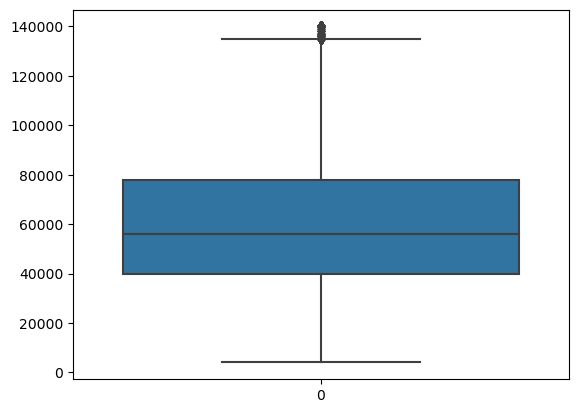

In [16]:
df_95 = df_final.annual_inc.quantile(0.95)
df_final = df_final[df_final.annual_inc <= df_95]
sns.boxplot(df_final["annual_inc"])

## Univariate Analysis using categorical data

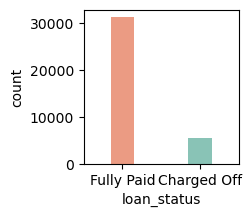

In [17]:
plt.figure(figsize=(2,2))
ax=sns.countplot(x='loan_status', width=0.3, palette=["#fc9272","#7fcdbb"],
               data=df_final)
plt.savefig('1.1.png',bbox_inches=Bbox([[-2,-2],fig.get_size_inches()]))


In [18]:
df_chargedoff = df_final[df_final.loan_status == 'Charged Off']
df_paid = df_final[df_final.loan_status == 'Fully Paid']


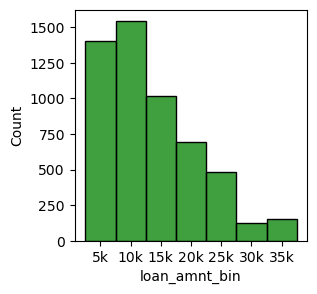

In [19]:
df_chargedoff['loan_amnt_bin']= pd.cut(df_chargedoff['loan_amnt'], bins=7, precision=0,labels=['5k','10k','15k','20k','25k','30k','35k'])

plt.figure(figsize=(3,3))
ax=sns.histplot(x='loan_amnt_bin', data=df_chargedoff,color='green')
plt.savefig('1.1.png',bbox_inches=Bbox([[-2,-2],fig.get_size_inches()]))


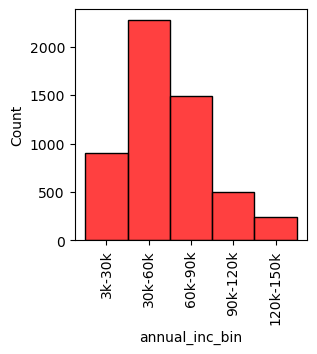

In [20]:
df_chargedoff['annual_inc_bin']= pd.cut(df_chargedoff['annual_inc'], bins=5, precision=0,labels=['3k-30k','30k-60k','60k-90k','90k-120k','120k-150k'])
plt.figure(figsize=(3,3))
plt.xticks(rotation=90)
ax=sns.histplot(x='annual_inc_bin', data=df_chargedoff,color='red')
plt.savefig('1.3.png',bbox_inches=Bbox([[-2,-2],fig.get_size_inches()]))

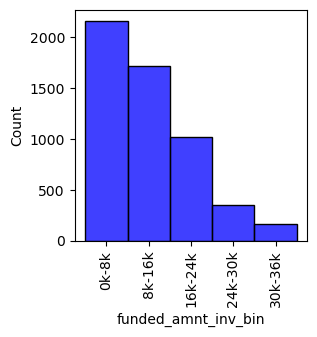

In [21]:
df_chargedoff['funded_amnt_inv_bin']= pd.cut(df_chargedoff['funded_amnt_inv'], bins=5, precision=0,labels=['0k-8k','8k-16k','16k-24k','24k-30k','30k-36k'])
plt.figure(figsize=(3,3))
plt.xticks(rotation=90)
ax=sns.histplot(x='funded_amnt_inv_bin', data=df_chargedoff,color='blue')
plt.savefig('1.4.png',bbox_inches=Bbox([[-2,-2],fig.get_size_inches()]))

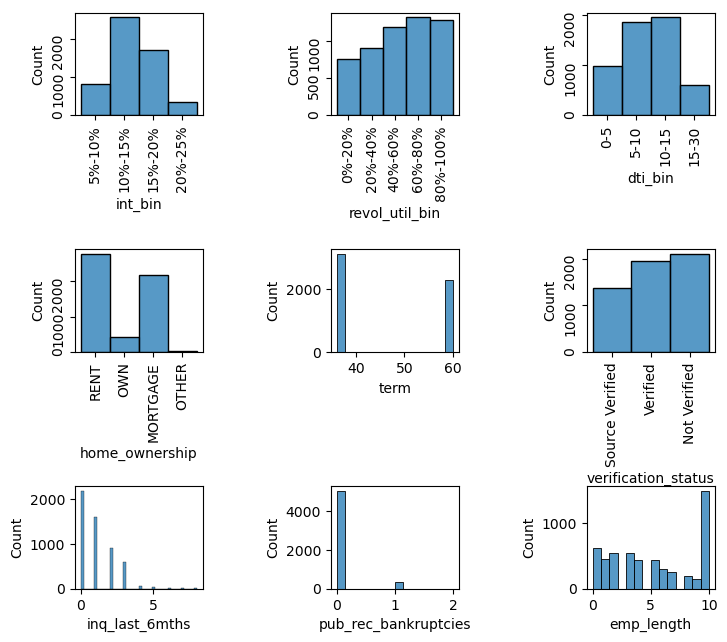

In [22]:

#  'grade', 'sub_grade', 
#        'purpose', 'addr_state', 

df_chargedoff['int_bin']= pd.cut(df_chargedoff['int_rate'], bins=4, precision=0,labels=['5%-10%','10%-15%','15%-20%','20%-25%'])
df_chargedoff['revol_util_bin']= pd.cut(df_chargedoff['revol_util'], bins=5, precision=0,labels=['0%-20%','20%-40%','40%-60%','60%-80%','80%-100%'])
df_chargedoff['dti_bin']= pd.cut(df_chargedoff['dti'], bins=4, precision=0,labels=['0-5','5-10','10-15','15-30'])

fig, axes = plt.subplots(3, 3)
plt.subplots_adjust(left=1, bottom=0, right=2, top=1.2, wspace=1, hspace=1.3)

ax1=sns.histplot(df_chargedoff["int_bin"], ax=axes[0,0])
ax1.tick_params(labelrotation=90)
ax2=sns.histplot(df_chargedoff["revol_util_bin"], ax=axes[0,1])
ax2.tick_params(labelrotation=90)
ax3=sns.histplot(df_chargedoff["dti_bin"], ax=axes[0,2])
ax3.tick_params(labelrotation=90)
ax4=sns.histplot(df_chargedoff["home_ownership"], ax=axes[1,0])
ax4.tick_params(labelrotation=90)
ax5=sns.histplot(df_chargedoff["term"], ax=axes[1,1])
ax6=sns.histplot(df_chargedoff["verification_status"], ax=axes[1,2])
ax6.tick_params(labelrotation=90)
ax7=sns.histplot(df_chargedoff["inq_last_6mths"], ax=axes[2,0])
ax8=sns.histplot(df_chargedoff["pub_rec_bankruptcies"], ax=axes[2,1])
ax9=sns.histplot(df_chargedoff["emp_length"], ax=axes[2,2])




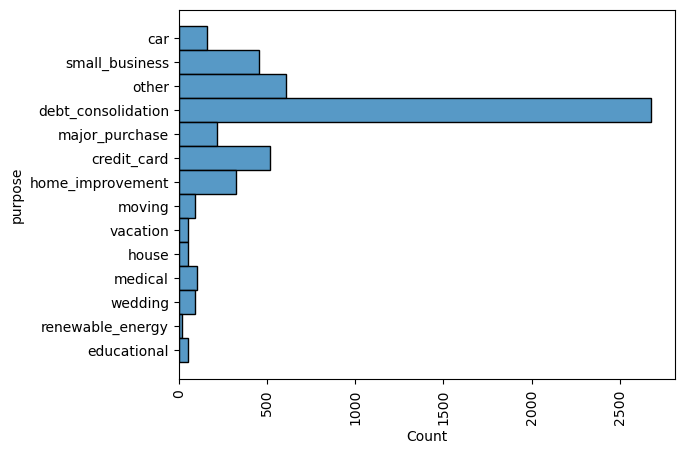

In [23]:
plt.xticks(rotation=90)
ax9=sns.histplot(data = df_chargedoff , y="purpose")


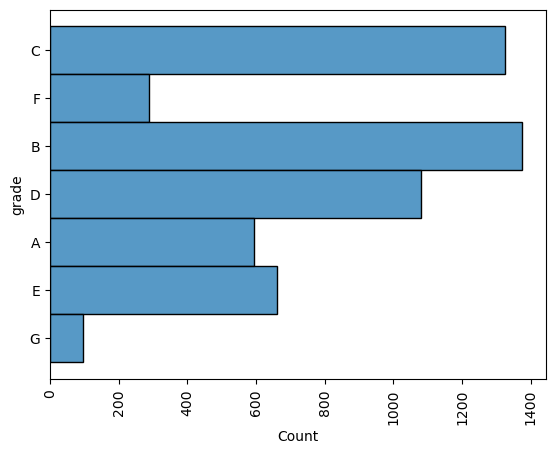

In [24]:
plt.xticks(rotation=90)
ax9=sns.histplot(data = df_chargedoff  ,y="grade")

# Bivariate Analysis
* Lets further check relation between two variables
  - Categorical v/s Numerical 

In [25]:
df_chargedoff.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'addr_state', 'dti', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'pub_rec_bankruptcies', 'loan_amnt_bin',
       'annual_inc_bin', 'funded_amnt_inv_bin', 'int_bin', 'revol_util_bin',
       'dti_bin'],
      dtype='object')

<Axes: xlabel='count', ylabel='purpose'>

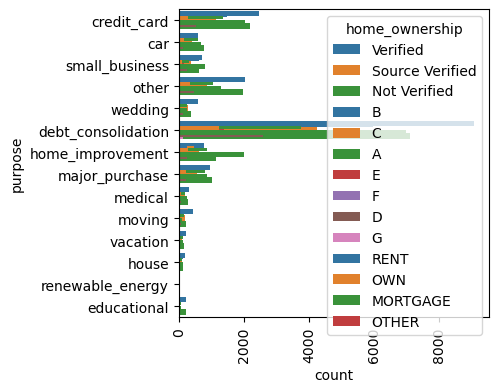

In [26]:
# Loan amount
plt.figure(figsize=(4,4))
plt.xticks(rotation=90)
sns.countplot(y=df_final['purpose'], hue=df_final['verification_status'])
sns.countplot(y=df_final['purpose'], hue=df_final['grade'])
sns.countplot(y=df_final['purpose'], hue=df_final['home_ownership'])


<Axes: xlabel='verification_status', ylabel='int_rate'>

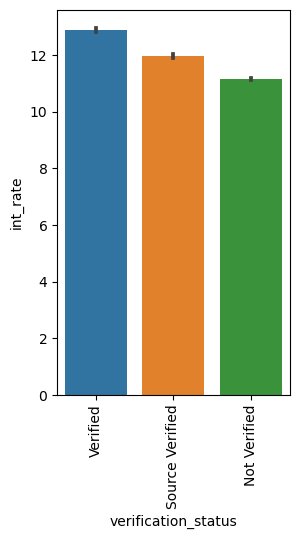

In [27]:
plt.figure(figsize=(3, 5))
plt.xticks(rotation='vertical')
sns.barplot(x=df_final['verification_status'], y=df_final['int_rate'])


Text(0, 0.5, 'defaulters')

<Figure size 300x300 with 0 Axes>

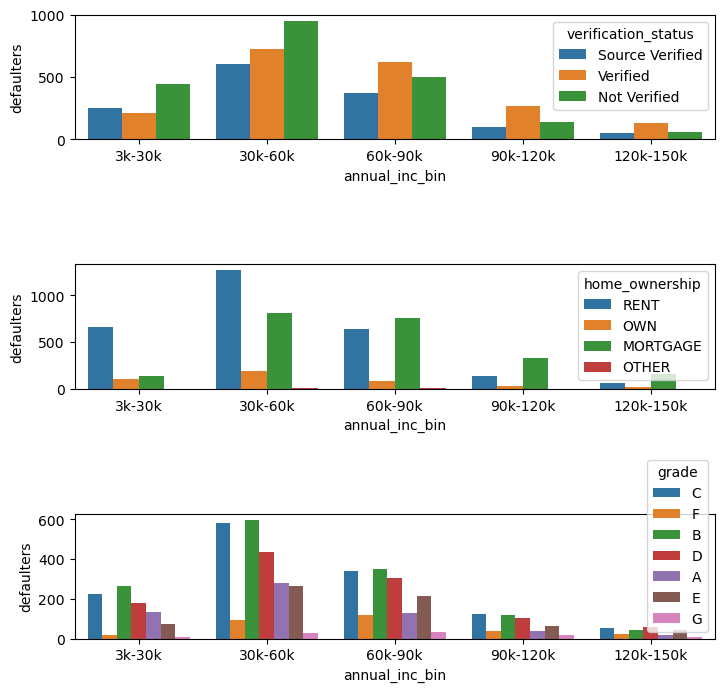

In [28]:

# Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
#        'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
#        'annual_inc', 'verification_status', 'issue_d', 'loan_status',
#        'purpose', 'addr_state', 'dti', 'inq_last_6mths', 'open_acc', 'pub_rec',
#        'revol_bal', 'revol_util', 'total_acc', 'total_pymnt',
#        'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
#        'total_rec_late_fee', 'pub_rec_bankruptcies', 'loan_amnt_bin',
#        'annual_inc_bin', 'funded_amnt_inv_bin', 'int_bin', 'revol_util_bin',
#        'dti_bin'],
#       dtype='object')
plt.figure(figsize=(3, 3))

fig, axes = plt.subplots(3)
plt.subplots_adjust(left=1.0, bottom=0, right=2, top=1.3, wspace=1, hspace=1)
sns.countplot(hue=df_chargedoff['verification_status'], x=df_chargedoff['annual_inc_bin'],ax=axes[0]).set_ylabel('defaulters')
sns.countplot(hue=df_chargedoff['home_ownership'], x=df_chargedoff['annual_inc_bin'],ax=axes[1]).set_ylabel('defaulters')
sns.countplot(hue=df_chargedoff['grade'], x=df_chargedoff['annual_inc_bin'],ax=axes[2]).set_ylabel('defaulters')


Text(0, 0.5, 'defaulters')

<Figure size 300x300 with 0 Axes>

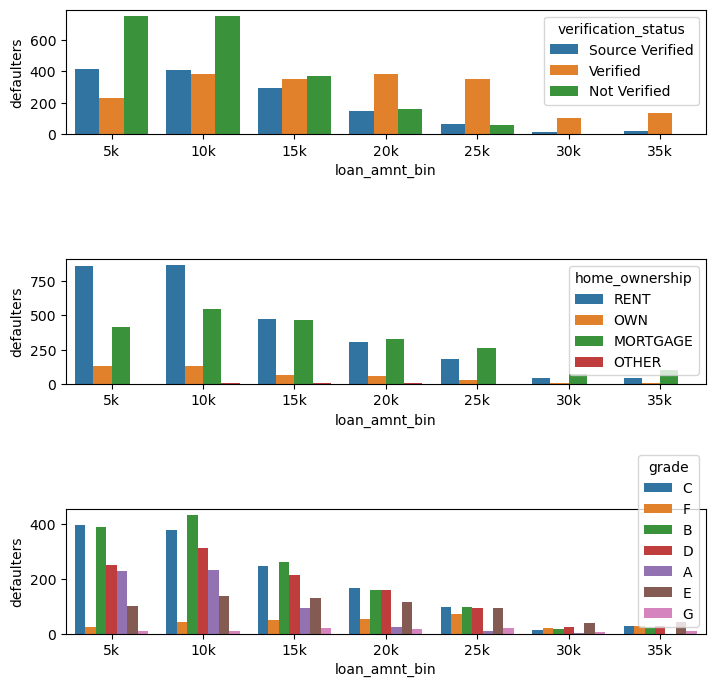

In [29]:
plt.figure(figsize=(3, 3))

fig, axes = plt.subplots(3)
plt.subplots_adjust(left=1.0, bottom=0, right=2, top=1.3, wspace=1, hspace=1)
sns.countplot(hue=df_chargedoff['verification_status'], x=df_chargedoff['loan_amnt_bin'],ax=axes[0]).set_ylabel('defaulters')
sns.countplot(hue=df_chargedoff['home_ownership'], x=df_chargedoff['loan_amnt_bin'],ax=axes[1]).set_ylabel('defaulters')
sns.countplot(hue=df_chargedoff['grade'], x=df_chargedoff['loan_amnt_bin'],ax=axes[2]).set_ylabel('defaulters')

Text(0, 0.5, 'defaulters')

<Figure size 300x300 with 0 Axes>

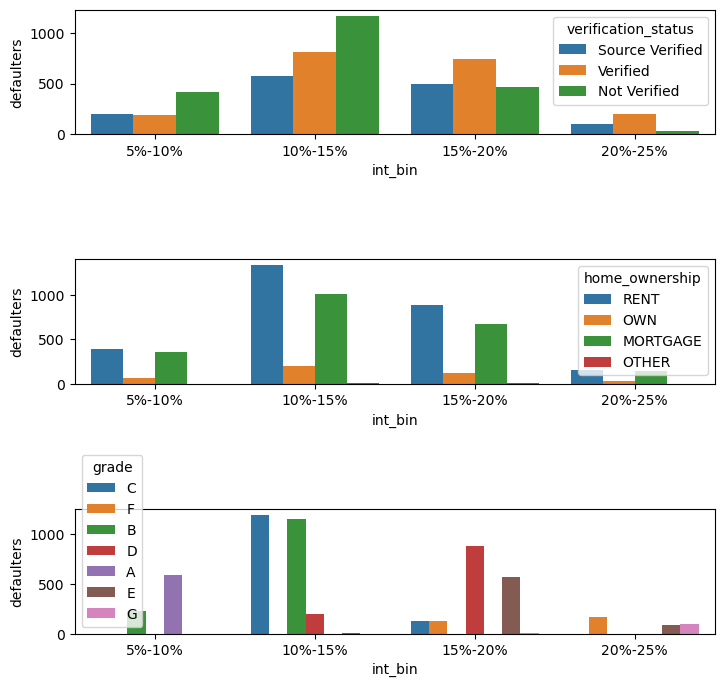

In [30]:
plt.figure(figsize=(3, 3))

fig, axes = plt.subplots(3)
plt.subplots_adjust(left=1.0, bottom=0, right=2, top=1.3, wspace=1, hspace=1)
sns.countplot(hue=df_chargedoff['verification_status'], x=df_chargedoff['int_bin'],ax=axes[0]).set_ylabel('defaulters')
sns.countplot(hue=df_chargedoff['home_ownership'], x=df_chargedoff['int_bin'],ax=axes[1]).set_ylabel('defaulters')
sns.countplot(hue=df_chargedoff['grade'], x=df_chargedoff['int_bin'],ax=axes[2]).set_ylabel('defaulters')

Text(0, 0.5, 'defaulters')

<Figure size 300x300 with 0 Axes>

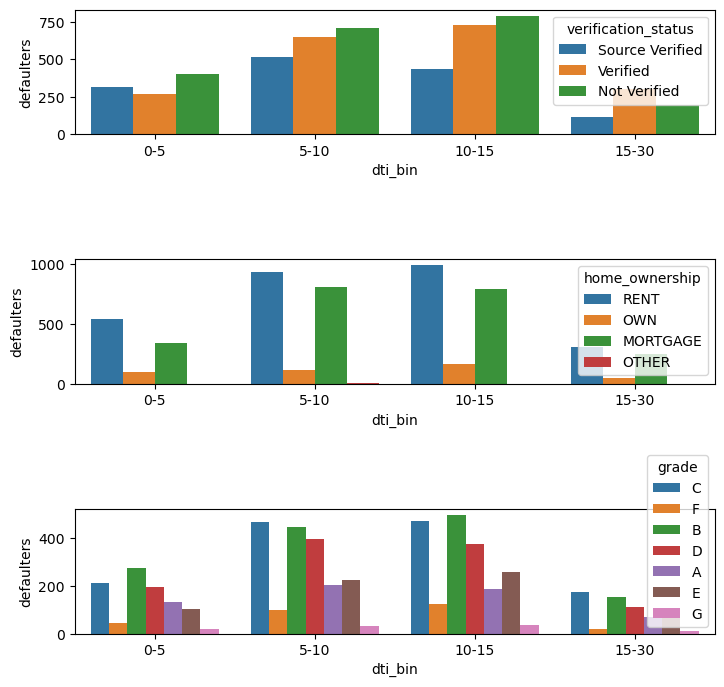

In [31]:
plt.figure(figsize=(3, 3))

fig, axes = plt.subplots(3)
plt.subplots_adjust(left=1.0, bottom=0, right=2, top=1.3, wspace=1, hspace=1)
sns.countplot(hue=df_chargedoff['verification_status'], x=df_chargedoff['dti_bin'],ax=axes[0]).set_ylabel('defaulters')
sns.countplot(hue=df_chargedoff['home_ownership'], x=df_chargedoff['dti_bin'],ax=axes[1]).set_ylabel('defaulters')
sns.countplot(hue=df_chargedoff['grade'], x=df_chargedoff['dti_bin'],ax=axes[2]).set_ylabel('defaulters')

KeyboardInterrupt: 

<Figure size 300x300 with 0 Axes>

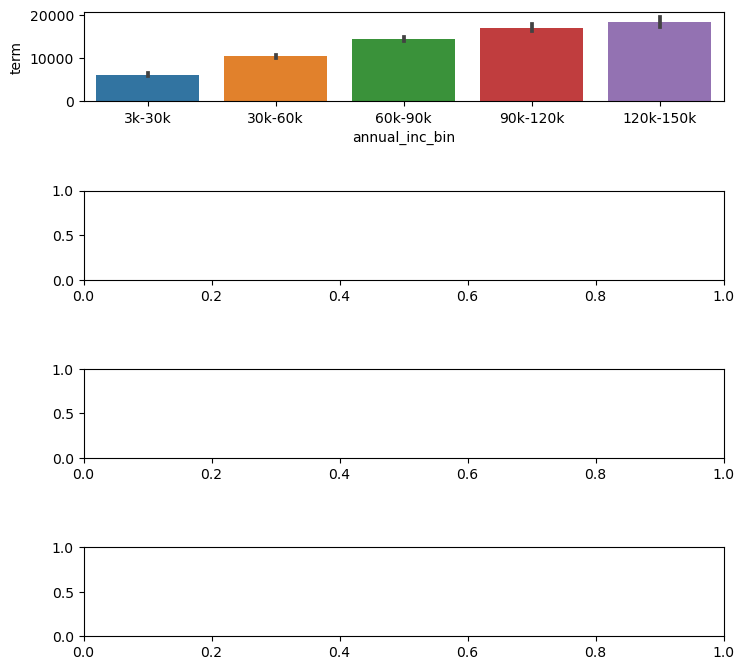

In [32]:
plt.figure(figsize=(3, 3))

fig, axes = plt.subplots(4)
plt.subplots_adjust(left=1.0, bottom=0, right=2, top=1.3, wspace=1, hspace=1)
sns.barplot(y=df_chargedoff['loan_amnt'], x=df_chargedoff['annual_inc_bin'],ax=axes[0]).set_ylabel('term')
sns.barplot(y=df_chargedoff['emp_length'], x=df_chargedoff['loan_amnt_bin'],ax=axes[1]).set_ylabel('emp_length')
sns.barplot(y=df_chargedoff['term'], x=df_chargedoff['loan_amnt_bin'],ax=axes[2]).set_ylabel('emp_length')
sns.barplot(y=df_chargedoff['emp_length'], x=df_chargedoff['annual_inc_bin'],ax=axes[3]).set_ylabel('emp_length')

<Axes: xlabel='annual_inc', ylabel='loan_amnt'>

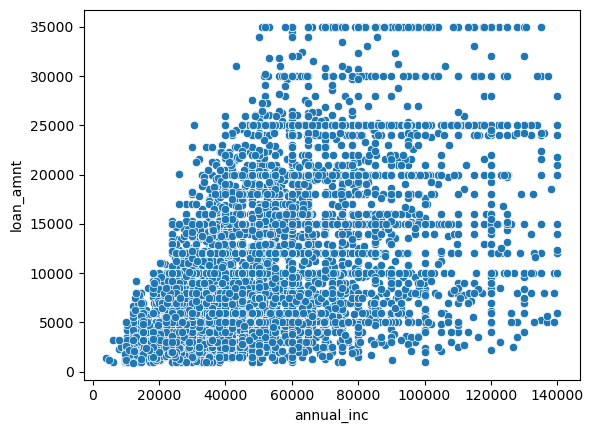

In [33]:
sns.scatterplot(y=df_chargedoff['loan_amnt'], x=df_chargedoff['annual_inc'])


<Axes: xlabel='annual_inc', ylabel='loan_amnt'>

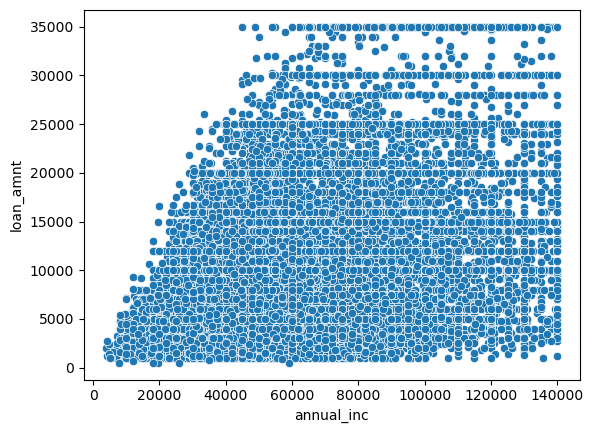

In [34]:
sns.scatterplot(y=df_paid['loan_amnt'], x=df_paid['annual_inc'])


# Multivariate Analysis
* getting correlation between numerical influencers

<Axes: >

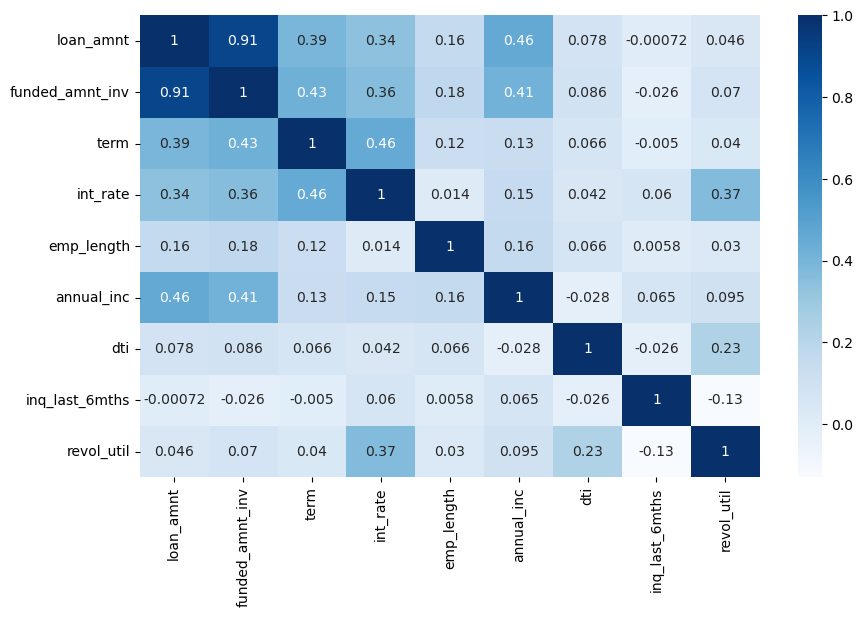

In [35]:
list_v = ['loan_amnt','funded_amnt_inv','term','int_rate','emp_length','annual_inc','dti','inq_last_6mths','revol_util']
df_heatmap = df_chargedoff[df_chargedoff.columns[df_chargedoff.columns.isin(list_v)]]

fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(df_heatmap.corr(), annot=True, cmap='Blues', annot_kws={'size': 10})


<Axes: >

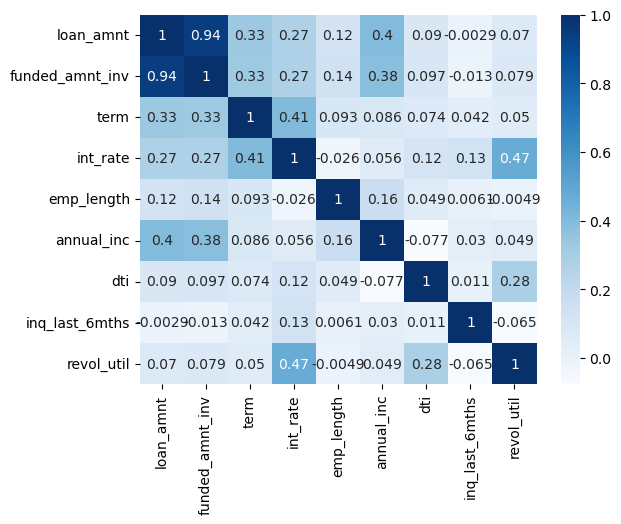

In [37]:
list_v = ['loan_amnt','funded_amnt_inv','term','int_rate','emp_length','annual_inc','dti','inq_last_6mths','revol_util']
df_heatmap = df_paid[df_paid.columns[df_paid.columns.isin(list_v)]]
sns.heatmap(df_heatmap.corr(), annot=True, cmap='Blues', annot_kws={'size': 10})


In [42]:
df_paid[df_paid.columns[df_paid.columns.isin(list_v)]].describe()

,loan_amnt,funded_amnt_inv,term,int_rate,emp_length,annual_inc,dti,inq_last_6mths,revol_util
count,31236.000000,31236.000000,31236.000000,31236.000000,31236.000000,31236.000000,31236.000000,31236.000000,31236.000000
mean,10486.245038,9768.243665,41.093354,11.563767,5.004354,61621.375137,13.332407,0.830708,47.451608
std,6874.267867,6587.432728,9.813324,3.575435,3.583304,27877.321854,6.668141,1.044224,28.217261
min,500.000000,0.000000,36.000000,5.420000,0.000000,4000.000000,0.000000,0.000000,0.000000
25%,5000.000000,4975.000000,36.000000,8.490000,2.000000,40000.000000,8.200000,0.000000,23.900000
50%,9000.000000,8200.000000,36.000000,11.490000,4.000000,57000.000000,13.430000,0.000000,47.500000
75%,14400.000000,13100.000000,36.000000,13.980000,9.000000,79000.000000,18.590000,1.000000,70.600000
max,35000.000000,35000.000000,60.000000,24.110000,10.000000,140004.000000,29.990000,8.000000,99.900000


In [43]:
df_chargedoff[df_chargedoff.columns[df_chargedoff.columns.isin(list_v)]].describe()

,loan_amnt,funded_amnt_inv,term,int_rate,emp_length,annual_inc,dti,inq_last_6mths,revol_util
count,5418.000000,5418.000000,5418.000000,5418.000000,5418.000000,5418.000000,5418.000000,5418.000000,5418.000000
mean,11812.260059,10620.240688,46.205980,13.757817,5.261720,56441.758234,14.105788,1.056663,55.193811
std,7884.861021,7463.184797,11.866233,3.630824,3.660174,26582.051520,6.587831,1.153816,28.003646
min,900.000000,0.000000,36.000000,5.420000,0.000000,4080.000000,0.000000,0.000000,0.000000
25%,5500.000000,4994.753432,36.000000,11.260000,2.000000,36297.750000,9.180000,0.000000,34.000000
50%,10000.000000,9000.000000,36.000000,13.490000,5.000000,51996.000000,14.410000,1.000000,57.900000
75%,16000.000000,14975.000000,60.000000,16.320000,10.000000,71287.000000,19.407500,2.000000,78.775000
max,35000.000000,35000.000000,60.000000,24.400000,10.000000,140004.000000,29.850000,8.000000,99.900000
